# 2021 Retail Data Analysis

### Harrison Gill

#### August 3, 2020

In [771]:
#Import necessary packages
import pandas as pd
from pandas import Series
import numpy as np
import itertools
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

In [772]:
stores = pd.read_csv("/Users/harrisonsgill/Documents/Job/Blackstone/undergrad_takehome_2020.csv")
#View schema of data
stores.head()

,Location number,Month,State,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned
0,1,1,TX,48628171.02,9218156.69,24278189.23,365880,4452,False
1,1,2,TX,48107179.24,10587747.35,25116844.41,365880,4452,False
2,1,3,TX,64352278.29,10193873.77,33703499.83,365880,4452,False
3,1,4,TX,45943677.96,8764165.00,24037719.47,365880,4452,False
4,1,5,TX,32761434.98,8022116.43,16432119.18,365880,4452,False


In [773]:
#check to see if there are null values
np.sum(pd.isnull(stores).head())

Location number       0
Month                 0
State                 0
Gross revenue         0
Fixed cost            0
Variable cost         0
Rental cost           0
Number of products    0
Owned                 0
dtype: int64

We can see that there are no missing values.

### Note: We will be scaling financial statistics to be measured in millions for ease of interpretation

In [774]:
stores['Gross revenue'] = stores['Gross revenue']/1000000
stores['Fixed cost'] = stores['Fixed cost']/1000000
stores['Variable cost'] = stores['Variable cost']/1000000
stores['Rental cost'] = stores['Rental cost']/1000000

## Part 1 - Summary Statistics and Plots

### Mean & median annual profit margins and distribution

In [775]:
#Create a data column with profit for each store
stores['profit'] = stores['Gross revenue'] - stores['Fixed cost']-stores['Variable cost'] - stores['Rental cost']

We must take in our data matrix and returns two vector: total profit, which contains
the annual total profit for each store location, and total revenue, which contains total annual revenue for each store. From there, we can divide them to get annual profit margin for each location.

In [776]:
#create empty vectors to store annual values of profit and revenue
prof_list = []
rev_list = []
#sum up the annual profit and revenue for each store over the twelve months
for i in range(int(stores['Location number'].max())):
    prof_list.append(sum(stores[stores['Location number']==i+1]['profit']))
    rev_list.append(sum(stores[stores['Location number']==i+1]['Gross revenue']))

Solve for profit margin from profit and revenue

In [777]:
#Convert datatype to NumPy array
np_prof_list = np.asarray(prof_list)
np_rev_list = np.asarray(rev_list)
#Calculate Profit Margin
annual_profit_margin = (np_prof_list/np_rev_list)*100

Store profit margins for each store in main dataframe

In [778]:
stores['Profit margin'] = list(itertools.chain.from_iterable(itertools.repeat(x, 12) for x in annual_profit_margin))

Note that if the dataset were much larger (>~2000 rows), I would not use the iterrows() functions, as it would be laborious computationally and vectorization would allow for quicker computation.

In [779]:
mean_PM = np.mean(annual_profit_margin)
print(f"Mean Profit Margin: {round(mean_PM,2)}x")

Mean Profit Margin: 24.86x


In [780]:
median_PM = np.median(annual_profit_margin)
print(f"Median Profit Margin: {round(median_PM,2)}x")

Median Profit Margin: 26.18x


### Plotting

Text(-12, 400, 'Frequency')

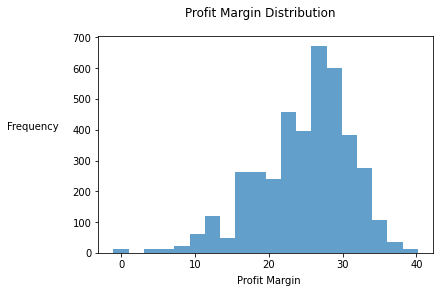

In [781]:
stores['Profit margin'].hist(bins=20, alpha=0.7, grid=False)
plt.suptitle('Profit Margin Distribution')
plt.text(20, -100, 'Profit Margin', ha='center')
plt.text(-12, 400, 'Frequency', ha='center')

In [782]:
quantiles = stores['Gross revenue'].quantile([.05,.25,.5,.75,.95])
print("The quartiles of Gross Revenue ($mm):\n",quantiles)

The quartiles of Gross Revenue ($mm):
 0.05    11.028885
0.25    18.828098
0.50    26.314156
0.75    37.271729
0.95    63.546547
Name: Gross revenue, dtype: float64


In [783]:
skew_test = mean_PM - median_PM
print(f'Difference between mean and median profit margin is ${round(skew_test,2)} mm')

Difference between mean and median profit margin is $-1.32 mm


We can see from the histogram plot that the data is not normally distributed, but rather left
skewed because of the tail on its left side. As supported by the quantile() function, it is clear that the first
quartile is much larger than fourth, and the second quartile is larger than the third. 

We can also see that the mean is significantly less than the median, indicating left skewed. This could be attributed to the fact that many stores, who underperformed the median, signficantly underperformed relative to the mean.

### Montly and Quarterly Aggregate Revenue

In [784]:
month_revenue = []
for i in range(12):
    month_revenue.append(sum(stores[stores['Month']==i+1]['Gross revenue']))

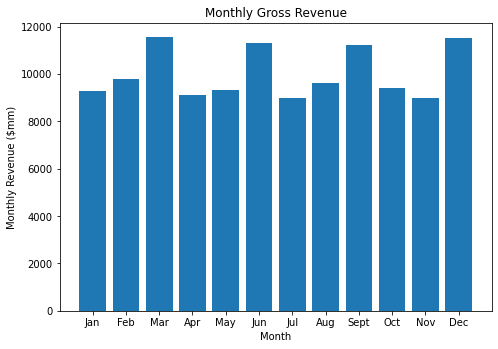

In [785]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
months = ["Jan", "Feb","Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]
ax.bar(months,month_revenue)
ax.set_ylabel('Monthly Revenue ($mm)')
ax.set_xlabel('Month')
ax.set_title('Monthly Gross Revenue')
plt.show()

We can begin to identify seasonal patterns in Gross Revenue, though in order to further compare these differences, a graph standardize by subtracting the average monthly revenue is below.

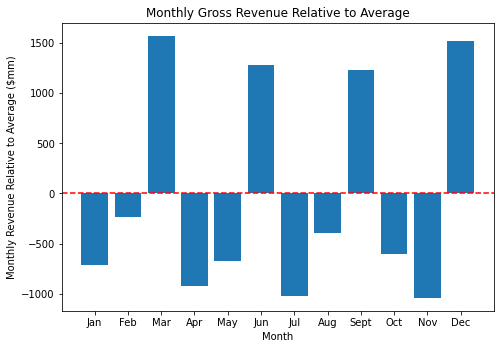

In [786]:
avg_revenue = np.asarray(month_revenue).mean()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
months = ["Jan", "Feb","Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]
ax.bar(months,month_revenue-avg_revenue)
ax.set_ylabel('Monthly Revenue Relative to Average ($mm)')
ax.set_xlabel('Month')
ax.set_title('Monthly Gross Revenue Relative to Average')
ax.axhline(y=0, color = "red", linestyle='dashed')
plt.show()

### Quarterly Aggregate Revenue

In [787]:
quarterly_revenue = []
for i in range(4):
    quarterly_revenue.append(sum(stores[(stores['Month']<=3*(i+1)) 
                                    & (stores['Month'] > 3*i)]['Gross revenue']))

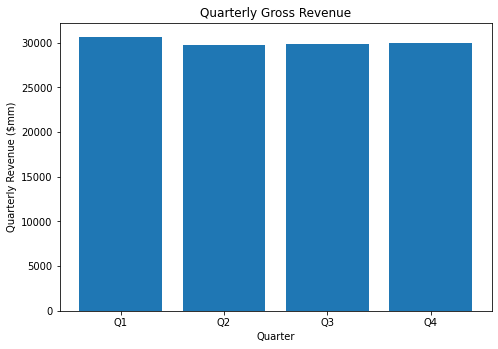

In [788]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
quarters = ['Q1', 'Q2', 'Q3', 'Q4']
ax.bar(quarters,quarterly_revenue)
ax.set_ylabel('Quarterly Revenue ($mm)')
ax.set_xlabel('Quarter')
ax.set_title('Quarterly Gross Revenue')

plt.show()

Similar to our transformation for monthly revenue, we will standardize quarterly revenue figures to analyze differences more closely.

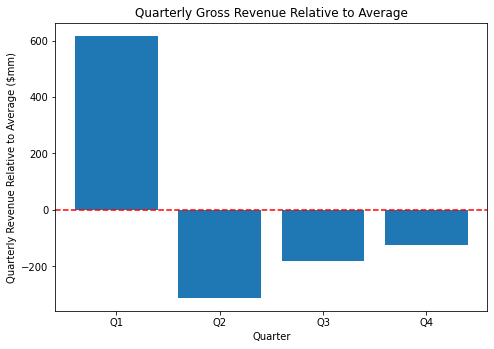

In [789]:
avg_revenue = np.asarray(quarterly_revenue).mean()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
quarters = ['Q1', 'Q2', 'Q3', 'Q4']
ax.bar(quarters,quarterly_revenue-avg_revenue)
ax.set_ylabel('Quarterly Revenue Relative to Average ($mm)')
ax.set_xlabel('Quarter')
ax.set_title('Quarterly Gross Revenue Relative to Average')
ax.axhline(y=0, color = "red", linestyle='dashed')
plt.show()

There is clearly seasonal fluctuation between months as well as seasons. 

* $\textbf{Monthly}$: the revenue appears to be cylical, reaching higher values in March, June, September, and December; though decreasing in the month after each of these

* $\textbf{Quarterly}$: Q1 represents the largest segment, while Q2, Q3, and Q4 have significantly less sales

## Part 2 - Cleaning the Data

To determine an "appropriate rental cost" for those buildings that are owned, I used the mean lease cost as a proxy for rental cost, and impute this value into the Rental Cost for stores which previously had no Rental Cost.

In [790]:
#Calculate the average monthly rent paid by stores that are not owned
monthly_average_rent = stores[stores['Owned']==0]['Rental cost'].mean()
print(f"Monthly average rent: ${round(monthly_average_rent,6)*1000000}")

Monthly average rent: $165627.0


In [791]:
#Impute this monthly average for each store that is Owned
stores['Rental cost'] = np.where(stores['Owned'] == 1, monthly_average_rent, stores['Rental cost'])

In [792]:
#Update the profit for each store
stores['profit'] = stores['Gross revenue'] - stores['Fixed cost']-stores['Variable cost'] - stores['Rental cost']

#### Recalculate the rent-adjusted profit margins

In [793]:
prof_list = []
rev_list = []
#sum up the annual profit
for i in range(int(stores['Location number'].max())):
    prof_list.append(sum(stores[stores['Location number']==i+1]['profit']))
    rev_list.append(sum(stores[stores['Location number']==i+1]['Gross revenue']))
np_prof_list = np.asarray(prof_list)
np_rev_list = np.asarray(rev_list)
annual_profit_margin = (np_prof_list/np_rev_list)*100

In [794]:
stores['Profit margin'] = list(itertools.chain.from_iterable(itertools.repeat(x, 12) for x in annual_profit_margin))

In [795]:
mean_PM = np.mean(annual_profit_margin)
print(f"Rent-adjusted Mean Profit Margin: {round(mean_PM,2)}x")
mean_PM = np.median(annual_profit_margin)
print(f"Rent-adjusted Median Profit Margin: {round(median_PM,2)}x")

Rent-adjusted Mean Profit Margin: 24.81x
Rent-adjusted Median Profit Margin: 26.18x


## Part 3 - Quantify Drivers of Success

In this stage, we will identify factors that have led to outperformance across locations, analyzing how profit margin varies with our variables. Specifically, we will focus more on how Profit Margin relates to our categorical variables: State, Ownernship status, and Month. This is because these factor could uncover trends to accelerate growth in stores other than more obvious modes. For example, it is self-evident that increases in revenue or decreases in costs will boost profit margins. Having said that, there are likely dependencies and interaction between our categorical and continuous variables, so we will attempt to identify which of these metrics are driving success.

### First we will analyze the relationship between Profit Margin and the State in which stores operate

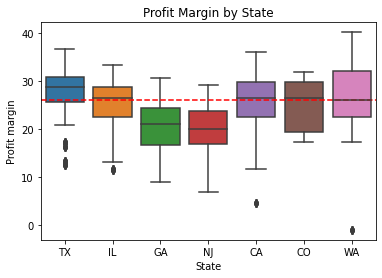

In [796]:
graph = sns.boxplot(y='Profit margin', x='State',data=stores)
graph.axhline(stores['Profit margin'].median(), color='red', linestyle='dashed')
plt.title('Profit Margin by State')
plt.show()

We can see that there are certain states that underperformed the median annual profit margin (i.e. New Jersey and Georgia), while stores in Texas significantly outperformed stores in the other states.

In order to determine why profit margins are higher in some states than others, we will evaluate revenue, variable cost, and number of products across different states.

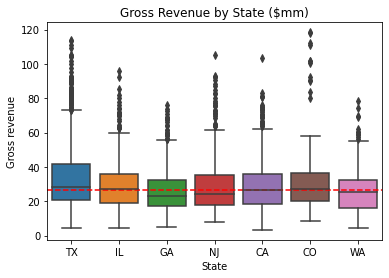

In [797]:
graph = sns.boxplot(y='Gross revenue', x = 'State', data=stores)
graph.axhline(stores['Gross revenue'].median(), color='red', linestyle='dashed')
plt.title('Gross Revenue by State ($mm)')
plt.show()

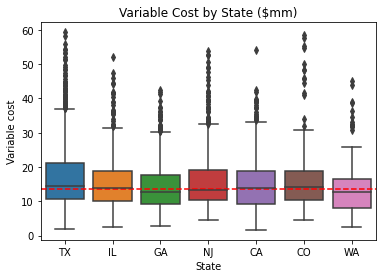

In [798]:
stores['Total Costs']=stores['Gross revenue']-stores['profit']
profit_graph = sns.boxplot(y='Variable cost', x = 'State', data=stores)
profit_graph.axhline(stores['Variable cost'].median(), color='red', linestyle='dashed')
plt.title('Variable Cost by State ($mm)')
plt.show()

#### Note that Number of products by State and Number of products by Month were both visualized in a box plot, though not included because of lack of insight provided from analysis
* For Number of products by month, there is no change in products month to month, which leads me to believe that this dataset did not track changes in store supply
* For Number of products by State, there were no conclusive trends, as all states had roughly 4500 products offered in each month

### Evaluation of monthly patterns in profit and costs

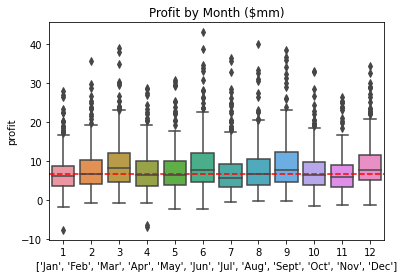

In [799]:
profit_graph = sns.boxplot(y='profit', x = 'Month', data=stores)
profit_graph.axhline(stores['profit'].median(), color='red', linestyle='dashed')
plt.title('Profit by Month ($mm)')
plt.xlabel(["Jan", "Feb","Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"])
plt.show()

Note we are using Profit, instead of Profit Margin because the Profit Margin is a uniform annual measure, so exactly uniform across the year, while Profit varies from month to month. We have already analyzed Revenue by month in $\textbf{Part 1}$, which followed a similar cyclical trend to the directly above graph. Therefore, we will be analyzing the variable cost per month next.

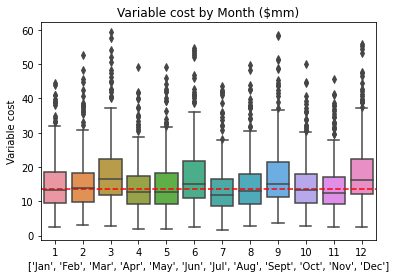

In [800]:
profit_graph = sns.boxplot(y='Variable cost', x = 'Month', data=stores)
profit_graph.axhline(stores['Variable cost'].median(), color='red', linestyle='dashed')
plt.title('Variable cost by Month ($mm)')
plt.xlabel(["Jan", "Feb","Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"])
plt.show()

As expected, variable cost rises in months where revenue is higher (more demand likely driving higher cost of goods sold and employee wages & hours worked). Revenue is signficantly higher than variable cost in months of strong performance, yielding higher profit.

### Evaluation of Ownership Impact on Profit Margin

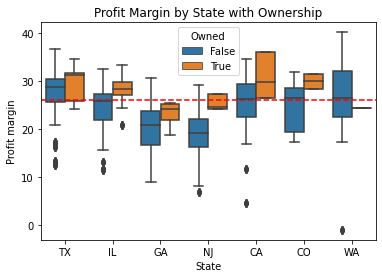

In [801]:
graph = sns.boxplot(y='Profit margin', x='State',data=stores, hue='Owned')
graph.axhline(stores['Profit margin'].median(), color='red', linestyle='dashed')
plt.title('Profit Margin by State with Ownership')
plt.show()

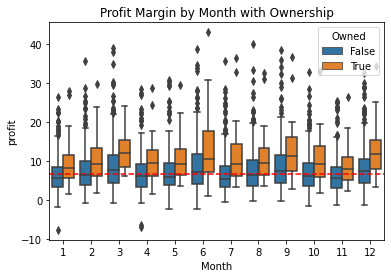

In [802]:
graph = sns.boxplot(y='profit', x='Month',data=stores, hue='Owned')
graph.axhline(stores['profit'].median(), color='red', linestyle='dashed')
plt.title('Profit Margin by Month with Ownership')
plt.show()

It is evident that across states, excluding Washington, that Profit Margins are higher for Owned Stores. Additionally, Profit Margins are higher in each month in stores that are owned. We must note that we made assumptions about the rental cost for those stores that may not be accurate. In future, asking owners of stores to report purchase price and date of purchase would allow us to calculate an approximate annual price paid for each store's "ownership cost" per month.

As was shown in the boxplot of Profit margin by state and ownership, it appears that owned stores have higher profit margins. We will perform an independent samples t-test to identify whether  there is a significant difference between the means of two groups (Owned vs. Non-owned)

In [803]:
Owned_pm = stores[stores['Owned']==True]['Profit margin']
Nonowned_pm = stores[stores['Owned']==False]['Profit margin']
t_stat, pvalue = stats.ttest_ind(Owned_pm, Nonowned_pm,equal_var=False)
print(f"We have a t-statistic of {round(t_stat,2)} and a P-value of {pvalue}.")

We have a t-statistic of 17.3 and a P-value of 1.303060547235446e-56.


This shows that there is a statistically signficant difference in profit margin between the owned and non-owned stores (P-value is less than signficance threshold of .05). Having said this, this large a t-statistic is concerningly high (and the corresponding p-value concerningly low), so further analysis should be done to determine the legitimacy of any conclusions drawn from this test.

### Other Analysis

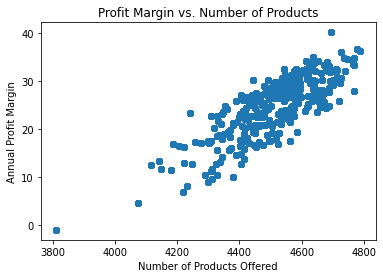

In [805]:
plot = plt.scatter(Products_ProfMarg['Number of products'], Products_ProfMarg['Profit margin'])
plt.title('Profit Margin vs. Number of Products')
plt.xlabel('Number of Products Offered')
plt.ylabel('Annual Profit Margin')
plt.show()

In [806]:
corr_mat = np.corrcoef(stores['Number of products'], Products_ProfMarg['Profit margin'])
print("Correlation Matrix: \n", corr_mat)
r_squared = (correlation_matrix[0,1])**2
print("\n R-Squared value: ",r_squared)

Correlation Matrix: 
 [[1.         0.80855744]
 [0.80855744 1.        ]]

 R-Squared value:  0.6537651357799145


It is evident from the scatter plot that there is a correlation between profit margin and number of products. Here we computed $\text{R}^2=\text{Correlation}_{x,y}^2$. The value of adjusted R-squared is 0.6537. This means that about 65% of the profit margin can be predicted solely from the input number of products. This value does not imply causality though, and it may be the case that stores with higher margins have the means to supply their stores with more products.

### Linear Models

Here we will be splitting the data into a known subset and an unknown subset to train our linear model on and then test on to see how the models perform. Further research could be conducted with machine learning and neural network models using this set up.

In [807]:
percent_split = .75
split_num = int(12*333*percent_split)
stores_known = stores.iloc[:split_num, :]
stores_unknown =stores.iloc[split_num+1:, :]

Intercept: -141.63105187847543
Coefficients: [0.03689667]
Mean Squared Error: 11.807764103662796


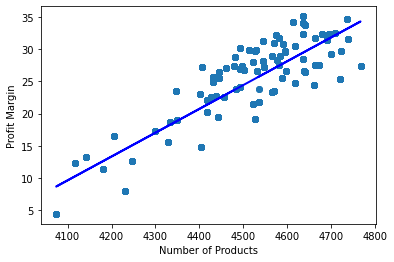

In [808]:
#Using sklearn, we can construct a linear model of how profit margin can be predicted using other variables
XTrain = stores[['Number of products']]
XTest = stores_unknown[['Number of products']]
YTrain = stores['Profit margin']
YTest = stores_unknown['Profit margin']
model = linear_model.LinearRegression()
model.fit(XTrain, YTrain)
print('Intercept:', model.intercept_)
print('Coefficients:', model.coef_)
YPred = model.predict(XTest)
print('Mean Squared Error:', mean_squared_error(YTest, YPred)) 
plt.scatter(XTest, YTest)
plt.plot(XTest, YPred, color='blue', linewidth=2)
plt.xlabel('Number of Products')
plt.ylabel('Profit Margin')
plt.show()

Furthering our visualization from above, we see how are model was able to predict profit margin by the number of products stocked in a store. The Mean Squared Error (MSE) value of 11.8 is relatively low considering we are only using one variable to predict profit margin. The positive coefficient in our linear model reinforces the positive relation we see visually.

In [809]:
#Using sklearn, we can construct a linear model of how profit margin can be predicted using other variables
XTrain = stores[['Variable cost','Gross revenue', 'Number of products']]
XTest = stores_unknown[['Variable cost','Gross revenue', 'Number of products']]
YTrain = stores['Profit margin']
YTest = stores_unknown['Profit margin']
model = linear_model.LinearRegression()
model.fit(XTrain, YTrain)
print('Intercept:', model.intercept_)
print('Coefficients:', model.coef_)
YPred = model.predict(XTest)
print('Mean Squared Error:', mean_squared_error(YTest, YPred)) 

Intercept: -109.69388883375862
Coefficients: [-1.47707154  0.81964542  0.02950342]
Mean Squared Error: 8.714467271772126


Our MSE in this prediction is lower than our last model, reaching 8.71. This would be expected as we added more information to help our model predict profit margin. As reinforcement to our data visualization conducted earlier, Gross revenue and Number of products are positively correlated with Profit margin and variable cost is negatively correlated with profit margin (see coefficients). 

In [810]:
#Using sklearn, we can construct a linear model of how profit margin can be predicted using other variables
#stores['State_num'] = stores['State_num'].astype('numeric') 
XTrain = stores[['Owned', 'Number of products']]
XTest = stores_unknown[['Owned', 'Number of products']]
YTrain = stores['Profit margin']
YTest = stores_unknown['Profit margin']
model = linear_model.LinearRegression()
model.fit(XTrain, YTrain)
print('Intercept:', model.intercept_)
print('Coefficients:', model.coef_)
YPred = model.predict(XTest)
print('Mean Squared Error:', mean_squared_error(YTest, YPred))

Intercept: -156.91684332334563
Coefficients: [-3.62481104  0.04037212]
Mean Squared Error: 10.308448401728285


The MSE in this model was lower than that when we just used number of products. The coefficient corresponding to the $Owned$ variable is negative, indicating that when stores are Owned (have a boolean value of 1), they have lower profit margins. I would question this model's results as we have seen that $Owned$ stores have generally higher profit margins.

In [811]:
#Using sklearn, we can construct a linear model of how profit margin can be predicted using other variables
#stores['State_num'] = stores['State_num'].astype('numeric') 
XTrain = stores[['Gross revenue', 'Variable cost', 'Fixed cost', 'Rental cost']]
XTest = stores_unknown[['Gross revenue', 'Variable cost', 'Fixed cost', 'Rental cost']]
YTrain = stores['Profit margin']
YTest = stores_unknown['Profit margin']
model = linear_model.LinearRegression()
model.fit(XTrain, YTrain)
print('Intercept:', model.intercept_)
print('Coefficients:', model.coef_)
YPred = model.predict(XTest)
print('Mean Squared Error:', mean_squared_error(YTest, YPred))

Intercept: 22.67333109840775
Coefficients: [ 1.4212384  -2.00789693 -1.41401858 -1.14561683]
Mean Squared Error: 20.380998596608254


This model has a large MSE which is likely due to overfitting. As we know, profit margin can be derived from revenue and costs, so theoretically, this model would be very good at predicting the profit margins of the data it's trained on. Therefore, I believe it was overfit to the training data and could not perform well on the testing data.

### Decompose Seasonal Data

In [812]:
#create a purely numeric dataset
from datetime import datetime
initial_date = np.array('2019-01', 'M')
months = initial_date + np.arange(12)
month_revenue = []
for i in range(12):
    month_revenue.append(sum(stores[stores['Month']==i+1]['Gross revenue']))
month_profit = []
for i in range(12):
    month_profit.append(sum(stores[stores['Month']==i+1]['profit']))
months = pd.Series(pd.date_range('1/1/2019', freq='M', periods=12))
seasonal_data = pd.DataFrame(
{
    'Months': months,
    #'Revenue': month_revenue,
    'Profit': month_profit
})
seasonal_data['Months'].to_string()
seasonal_data

,Months,Profit
0,2019-01-31,2236.472710
1,2019-02-28,2587.055437
2,2019-03-31,3109.286336
3,2019-04-30,2379.929928
4,2019-05-31,2554.876622
5,2019-06-30,3018.994222
6,2019-07-31,2406.602839
7,2019-08-31,2676.069619
8,2019-09-30,3031.673177
9,2019-10-31,2504.222891


In [813]:
'''
seasonal_df = seasonal_decompose(seasonal_data, model='additive')
result.plot()
pyplot.show()
'''

"\nseasonal_df = seasonal_decompose(seasonal_data, model='additive')\nresult.plot()\npyplot.show()\n"

Note that I was going to seasonally decompose the data to strip seasonal trends from confounding the data. This would have allowed for a much more informative picture of the actual trend of profit over time. However, the dataset provided only provided data for one year. As described in its documentation, the seasonal_decompose() function needs at least two cycles of dates to return a model. The additive model, which we would have used represents the following model:
$$Y_t = T_t+S_t+e_t$$ 
$$\text{where }Y_t\text{ is Profit Margin, }T_t\text{ is the trend over time, }S_t\text{ is Seasonal aspect, and }e_t\text{ is the error over time}$$

## Email to CEO

Hello,

I hope you are doing well. After analyzing the financial performance of our stores across the country, it is clear that there are many factors contributing to the success of our company, as well as ways in which we can improve. First, our Profit Margins are extremely strong, an average of 24.8x, while the rest of the retail industry usually achieves 1x - 4x Profit Margins. Unfortunately, there are many stores with signficantly lower profit margin than our average, and to boost the profitability of the company, we must increase the success of these locations or allocate our resources elsewhere.

The performance of our stores appears to be seasonal, as Quarter 1 yielded substantially larger profit margins than the remaining three quarters. Additionally, consumers appear to be shopping in cylcical patterns, with heightened spending in the months of March, July, September, and December. Because of these two factors, I recommend that we increase both our staffing and our hours of operations in these designated time frames. These changes will increase variable costs, though as I explained above, signficant revenue increase will offset these costs.

There are many characteristics that are consistently strong indicators of our stores’ success. Primarily, we can see that there are regional differences when looking at the profit margin of our stores by state. I would advise that we relocate some of our least profitable locations in Georgia and New Jersey to Texas or California, where our branches have outperformed our average store. Additionally, we should increase the number of products offered in each store. There is a moderately strong positive correlation between the number of products a store offers and its profit margin. Finally, it can be observed that stores that are owned generally have higher annual profit margins. Having said this, there must be further analysis conducted regarding this conclusion because of assumptions made about a proxy for rental cost for stores that are owned. There could be confounding variables linked to each of the characteristics that were provided in the dataset, which could be mitigated with better data.

Going forward, it would be extremely helpful for the company to record the following to optimize our data analysis: 
* Multiple years of performance to create time-series data to identify change of profit margin at an individual store when other variables are altered, as well as create seasonally-decomposed models
* Breakdown of Fixed costs (i.e. salaries, property taxes, etc.)
* Breakdown of variable costs (i.e. COGS, utilities costs, etc.)
* Breakdown of inventory (quantity and price)

I hope that these findings prove to be useful in the upcoming year. Please let me know if any further data
analysis needs to be conducted.

Best regards,

Harrison